In [1]:
import torch
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

from mmengine.config import Config

from tools.test import check_accuracy
from tools.data_poison import data_poison
from modules.vgg import vgg13_bn

In [2]:
%load_ext autoreload
%autoreload 2

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


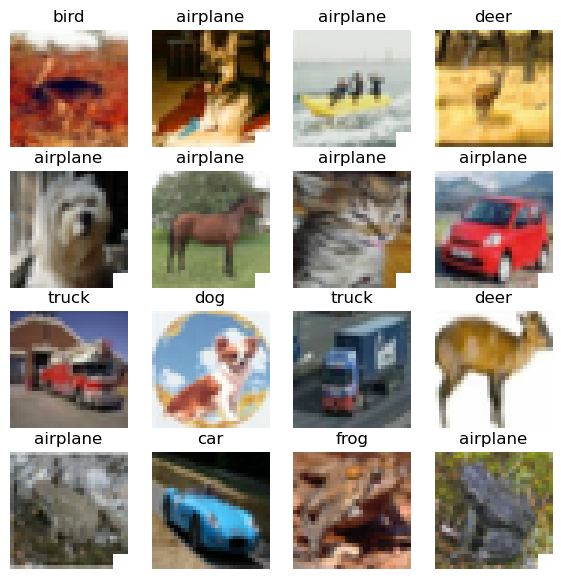

In [3]:
cfg = Config.fromfile('./configs/vgg13_bn.py')

classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(7, 7))
for i in range(16):
    img, label = cfg.dset_train[i]
    img = img.numpy().transpose(1, 2, 0)
    img = (img * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])) * 255

    plt.subplot(4, 4, i + 1)
    plt.axis('off')
    plt.title(classes[label])
    plt.imshow(img.astype('uint8'))


In [4]:
batch_size = 128

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

clean_dset_test = dset.CIFAR10('./data', train=False, download=True, transform=transform_test)
loader_clean_test = DataLoader(clean_dset_test, batch_size=batch_size, num_workers=2)

poisoned_dset_test = data_poison(clean_dset_test, 1, 0, combine=False)
loader_poisoned_test = DataLoader(poisoned_dset_test, batch_size=batch_size, num_workers=2)

Files already downloaded and verified


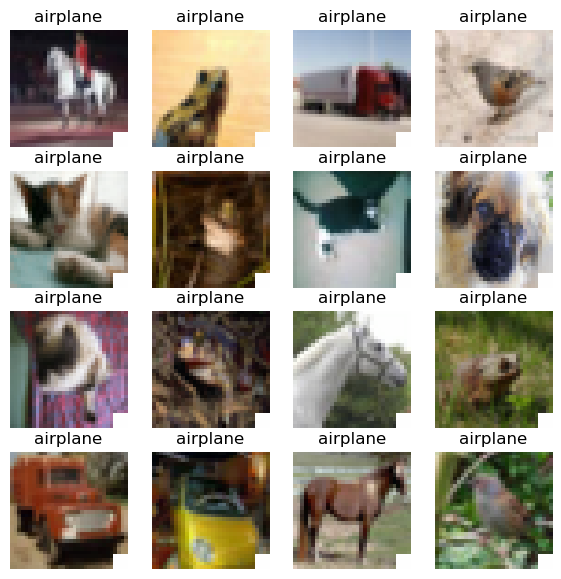

In [5]:
classes = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(7, 7))
for i in range(16):
    img, label = poisoned_dset_test[i]
    img = img.numpy().transpose(1, 2, 0)
    img = (img * np.array([0.2023, 0.1994, 0.2010]) + np.array([0.4914, 0.4822, 0.4465])) * 255

    plt.subplot(4, 4, i + 1)
    plt.axis('off')
    plt.title(classes[label])
    plt.imshow(img.astype('uint8'))


In [7]:
ratio = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
CDA = list()
ASR = list()
vgg13_bn_ = vgg13_bn(num_classes=10)
for r in ratio:
    # load pretrained weights
    name = str(r).replace('.', '')
    pth_file = './pth_files/' + name + '.pth'
    vgg13_bn_.load_state_dict(torch.load(pth_file))

    # test
    cda = check_accuracy(loader_clean_test, vgg13_bn_)
    asr = check_accuracy(loader_poisoned_test, vgg13_bn_)

    CDA.append(cda)
    ASR.append(asr)
    print('ratio:%.1f  cda:%.2f%%  asr:%.2f%%' % (r, 100 * cda, 100 * asr))


FileNotFoundError: [Errno 2] No such file or directory: './pth_files/00.pth'